Evaluation of RF Model Based On Confusion Metrics
Mean accuracy of RF 0.8974432204542364
Mean precision of RF 0.8939930032691625
Mean recall of RF 0.8983746112011459
Mean F1 score of RF 0.8959148608325067
Mean AUC score of RF 0.9585544604930398
Threshold value is: 0.69
Optimal tpr is: 0.891566265060241
Optimal fpr is: 0.033707865168539325
Threshold value is: 0.43
Optimal tpr is: 0.9302325581395349
Optimal fpr is: 0.11627906976744186
Threshold value is: 0.67
Optimal tpr is: 0.8433734939759037
Optimal fpr is: 0.056179775280898875
Threshold value is: 0.48
Optimal tpr is: 0.9259259259259259
Optimal fpr is: 0.08888888888888889
Threshold value is: 0.48
Optimal tpr is: 0.9101123595505618
Optimal fpr is: 0.0975609756097561


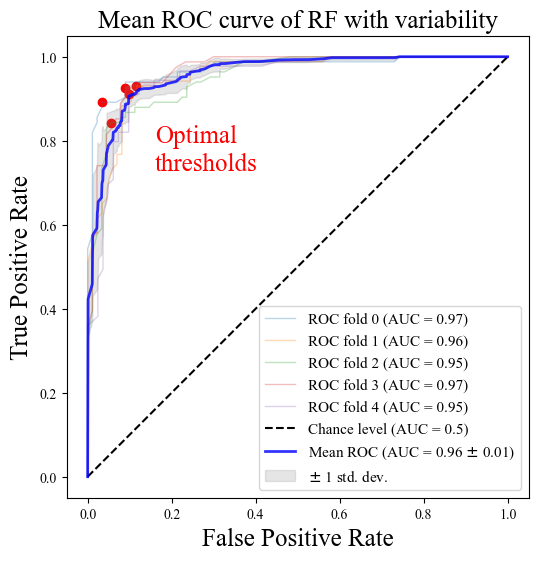

C:\Users\junxi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- DEM
- Fire
- Solar_year
- Water_content
- Weight
Feature names seen at fit time, yet now missing:
- BulkDensity
- Elevation
- FieldCapacity
- PISR
- Wildfire

  warnings.warn(message, FutureWarning)


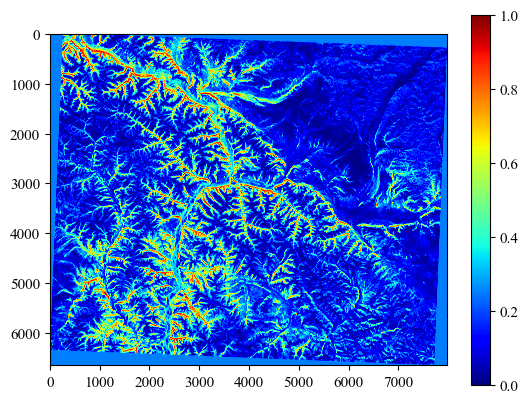

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve

from skimage import io
import imagecodecs
from osgeo import gdal
import numpy as np

# Data loading
data = pd.read_csv("Input Data.csv")

# Define Input and Target variables
X = data.drop('label',axis = 'columns')
y = data['label']

# Define k-fold validation
folds = KFold(n_splits=5, random_state=123, shuffle=True)
np.random.seed(123)
random.seed(123)

# Define ML Models
# Logistic Regression
classifier_logistic = LogisticRegression(solver='lbfgs', random_state=123)
# SVM
classifier_SVM = svm.SVC(kernel='rbf', C=1, gamma=0.0001, probability=True, random_state=123)
# Random Forest
classifier_RF = RandomForestClassifier(n_estimators=100, random_state=123)
# Gradientboost
classifier_GB = GradientBoostingClassifier(learning_rate=0.1, random_state=123)

# Train the RF model
accuracy_sub = []
precision_sub = []
recall_sub = []
f1score_sub = []
roc_auc_score_sub = []

for train_index, test_index in folds.split(X):
    
    X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], \
                                       y.loc[train_index], y.loc[test_index]
        
    model = classifier_RF
    model.fit(X_train, y_train)
    y_preds_train = model.predict(X_train)
    #print(precision_score(y_train, y_preds_train))
    
    y_preds = model.predict(X_test)
    y_preds_proba = model.predict_proba(X_test)[:, 1]
    accuracy_sub.append(accuracy_score(y_test, y_preds))
    precision_sub.append(precision_score(y_test, y_preds))
    recall_sub.append(recall_score(y_test, y_preds))
    f1score_sub.append(f1_score(y_test, y_preds))
    roc_auc_score_sub.append(roc_auc_score(y_test, y_preds_proba))
    
mean_accuracy = np.nanmean(accuracy_sub)
mean_precision = np.nanmean(precision_sub)    
mean_recall = np.nanmean(recall_sub)
mean_f1score = np.nanmean(f1score_sub)
mean_AUC_score = np.nanmean(roc_auc_score_sub)

print('Evaluation of RF Model Based On Confusion Metrics')
print('Mean accuracy of RF', mean_accuracy)
print('Mean precision of RF', mean_precision)
print('Mean recall of RF', mean_recall)
print('Mean F1 score of RF', mean_f1score)
print('Mean AUC score of RF', mean_AUC_score)

plt.rcParams["font.family"] = "Times New Roman"


# RF roc curve display
classifier = classifier_RF

tprs = []
aucs = []
optimalthreshold = []
mean_fpr = np.linspace(0, 1, 1000)

fig, ax = plt.subplots(figsize=(6, 6))

for fold, (train_index, test_index) in enumerate(folds.split(X, y)):
    
    X_train, X_test, y_train, y_test = X.loc[train_index], X.loc[test_index], \
                                       y.loc[train_index], y.loc[test_index]
    
    classifier.fit(X_train, y_train)
    
    y_pred = classifier.predict_proba(X_test)
    y_pred = y_pred[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    optimal_tpr = tpr[optimal_idx]
    optimal_fpr = fpr[optimal_idx]
    optimalthreshold.append(optimal_threshold)
    print("Threshold value is:", optimal_threshold)
    print("Optimal tpr is:", optimal_tpr)
    print("Optimal fpr is:", optimal_fpr)
    
    # visualize roc curve with cross-validation
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    
    ax.scatter(optimal_fpr, optimal_tpr, color='r')
    
plt.text(0.16, 0.73, 'Optimal'+'\n'+'thresholds',fontsize = 18, color='r')#'Mean optimal threshold is:\n{}'.format(round(statistics.mean(optimalthreshold), 4)),fontsize = 12, color='r')    
#plt.text(0, 0.96, '(c)',fontsize = 18, color='k')
ax.plot([0, 1], [0, 1], "k--", label="Chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Mean ROC curve of RF with variability",
)

matplotlib.rcParams.update({'font.size': 11})
ax.set_xlabel('False Positive Rate', fontsize = 18)
ax.set_ylabel('True Positive Rate', fontsize = 18)
ax.title.set_size(18)

ax.axis("square")
ax.legend(loc="lower right")

plt.savefig("RF.svg", format="svg")
plt.show()

# LSM
DEM = io.imread('Extract_DEM.tif').ravel()
Slope = io.imread('Extract_Slope.tif').ravel()
PISR = io.imread('Solar_radiation.tif').ravel()
#PISR_1 = PISR[:, :, 0]
#PISR_2 = PISR[:, :, 1]
#PISR_3 = PISR[:, :, 2]
#b1_PISR = PISR_1.ravel()
#b2_PISR = PISR_2.ravel()
#b3_PISR = PISR_3.ravel()
tpi = io.imread('Extract_tpi_new.tif').ravel()
Fire = io.imread('Extract_fire.tif').ravel()
TWI = io.imread('Extract_TWI.tif').ravel()
SPI = io.imread('Extract_SPI.tif').ravel()
Aspect = io.imread('Extract_Aspect.tif').ravel()
PlanCurvature = io.imread('Extract_PlanCurvature.tif').ravel()
ProfileCurvature = io.imread('Extract_ProfileCurvature.tif').ravel()
Texture = io.imread('Extract_Texture.tif').ravel()
Water_content = io.imread('Extract_Water_content.tif').ravel()
Weight = io.imread('Extract_Weight.tif').ravel()
NDVI = io.imread('Extract_NDVI.tif').ravel()
Sand = io.imread('Extract_Sand.tif').ravel()
Clay = io.imread('Extract_Clay.tif').ravel()

# DataFrame
d = {
    'Fire':Fire,
    'DEM':DEM,
    'Slope':Slope,
    'TPI':tpi,
    'TWI':TWI,
    'SPI':SPI,
    'Aspect':Aspect,
    'PlanCurvature':PlanCurvature,
    'ProfileCurvature':ProfileCurvature,
    'Texture':Texture,
    'Water_content':Water_content,
    'Weight':Weight,
    'NDVI':NDVI,
    'Sand':Sand,
    'Clay':Clay,
    'Solar_year':PISR}

df = pd.DataFrame(d)
df = df.fillna(0)

# Probability
predicion_results = classifier_RF.predict_proba(df)
risk = predicion_results[:,1]

reshape_risk = np.reshape(risk, ((6659, 7971)))
risk_map = plt.imshow(reshape_risk, 'jet', vmin = 0, vmax = 1)
plt.colorbar(risk_map)

# Save as geotiff file
#print(reshape_risk.dtype)
def read_geotiff(filename):
    ds = gdal.Open(filename)
    band = ds.GetRasterBand(1)
    arr = band.ReadAsArray()
    return arr, ds

def write_geotiff(filename, arr, in_ds):
    if arr.dtype == np.float64:   
        arr_type = gdal.GDT_Float64
    else:
        arr_type = gdal.GDT_Int64

    driver = gdal.GetDriverByName("GTiff")
    out_ds = driver.Create(filename, arr.shape[1], arr.shape[0], 1, arr_type)
    out_ds.SetProjection(in_ds.GetProjection())
    out_ds.SetGeoTransform(in_ds.GetGeoTransform())
    band = out_ds.GetRasterBand(1)
    band.SetNoDataValue(0)
    band.WriteArray(arr)
    band.FlushCache()
    band.ComputeStatistics(False)

reference_arr, reference_ds = read_geotiff("Extract_DEM.tif")

write_geotiff("LSM.tif", reshape_risk, reference_ds)